In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import math

spark = SparkSession.builder.appName("Analysis").getOrCreate()

base_path = 'dbfs:/FileStore/shared_uploads/srikalpasankeerth32@gmail.com/'

In [0]:
keys_df = spark.read.csv(f'{base_path}KEYS.csv', header=True, inferSchema=True).toPandas()
census_population_df = spark.read.csv(f'{base_path}CENSUS_POPULATION_STATE.tsv', header=True, inferSchema=True, sep='\t').toPandas()
census_mhi_df = spark.read.csv(f'{base_path}CENSUS_MHI_STATE.csv', header=True, inferSchema=True).toPandas()
redfin_price_df_raw = spark.read.csv(f'{base_path}REDFIN_MEDIAN_SALE_PRICE.csv', header=True, inferSchema=True).toPandas()

new_header = redfin_price_df_raw.iloc[0]
redfin_price_df = redfin_price_df_raw[1:].copy()
redfin_price_df.columns = new_header
if len(redfin_price_df.columns) > 0:
    redfin_price_df.rename(columns={redfin_price_df.columns[0]: 'Region'}, inplace=True)
redfin_price_df.reset_index(drop=True, inplace=True)

# Keys

In [0]:
filtered_keys = keys_df[(keys_df['region_type'] == 'state') & (~keys_df['key_row'].str.contains("'", na=False))].reset_index(drop=True)
output_df = pd.DataFrame({
    'key_row': filtered_keys['key_row'],
    'StateCode': filtered_keys['zillow_region_name']
})

# Helper Functions
def ordinal_suffix(rank):
    if pd.isna(rank) or (isinstance(rank, float) and math.isnan(rank)): return ''
    rank_int = int(rank)
    if 11 <= rank_int % 100 <= 13: return 'th'
    return {1: 'st', 2: 'nd', 3: 'rd'}.get(rank_int % 10, 'th')

def format_rank_column(rank):
    if pd.isna(rank) or (isinstance(rank, float) and math.isnan(rank)): return ''
    rank_int = int(rank)
    return f"{rank_int}{ordinal_suffix(rank_int)}"

def format_currency_column(value):
    if pd.isna(value) or (isinstance(value, float) and math.isnan(value)): return ''
    return f"${float(value):,.0f}"

def clean_numeric_value(val, chars_to_remove=['$', ',']):
    if isinstance(val, str):
        for char in chars_to_remove:
            val = val.replace(char, '')
    return pd.to_numeric(val, errors='coerce')

# Census Population

In [0]:
def get_population(code):
    row = census_population_df[census_population_df.iloc[:, 0].str.strip() == "Total population"]
    val = row.get(f"{code}!!Estimate", pd.Series([np.nan], dtype=object)).values[0]
    return clean_numeric_value(val)

output_df['census_population_numeric'] = output_df['StateCode'].apply(get_population)
output_df['population_rank'] = output_df['census_population_numeric'].rank(ascending=False, method='min').astype('Int64')

output_df['population_blurb'] = output_df.apply(
    lambda row: f"{str(row['key_row']).capitalize()} is {format_rank_column(row['population_rank'])} in the nation in population among states, DC, and Puerto Rico."
                if pd.notna(row['population_rank']) else f"{str(row['key_row']).capitalize()} population data or rank is unavailable.",
    axis=1
)

# Income

In [0]:
def get_income(code):
    row = census_mhi_df[census_mhi_df.iloc[:, 0].str.strip() == "Households"]
    val = row.get(f"{code}!!Median income (dollars)!!Estimate", pd.Series([np.nan], dtype=object)).values[0]
    return clean_numeric_value(val)

output_df['median_household_income'] = output_df['StateCode'].apply(get_income)
output_df['median_household_income_rank'] = output_df['median_household_income'].rank(ascending=False, method='min').astype('Int64')

def income_blurb(row):
    rank = row['median_household_income_rank']
    key = str(row['key_row']).capitalize()
    if pd.isna(rank): return f"{key} median household income data or rank is unavailable."
    rank_formatted = format_rank_column(rank)
    return f"{key} has the highest median household income in the nation among states, DC, and Puerto Rico." if int(rank) == 1 else f"{key} is {rank_formatted} in the nation in median household income among states, DC, and Puerto Rico."

output_df['median_household_income_blurb'] = output_df.apply(income_blurb, axis=1)

# Sale Price

In [0]:
latest_month_label = redfin_price_df.columns[-1]
print(f"Using Redfin data from: {latest_month_label}")

def get_sale_price(code):
    if 'Region' not in redfin_price_df.columns or latest_month_label not in redfin_price_df.columns: return np.nan
    row_index = redfin_price_df[redfin_price_df['Region'].astype(str).str.strip() == str(code)].index
    if row_index.empty: return np.nan

    val = redfin_price_df.loc[row_index[0], latest_month_label]
    if pd.isna(val): return np.nan
    if isinstance(val, (int, float)): return float(val)
    if isinstance(val, str):
        cleaned_val = val.strip().replace('$', '').replace(',', '')
        multiplier = 1
        if 'K' in cleaned_val.upper(): multiplier = 1000; cleaned_val = cleaned_val.upper().replace('K', '')
        elif 'M' in cleaned_val.upper(): multiplier = 1000000; cleaned_val = cleaned_val.upper().replace('M', '')
        numeric_val = pd.to_numeric(cleaned_val, errors='coerce')
        return numeric_val * multiplier if pd.notna(numeric_val) else np.nan
    return np.nan

output_df['median_sale_price'] = output_df['StateCode'].apply(get_sale_price)
output_df['median_sale_price'] = pd.to_numeric(output_df['median_sale_price'], errors='coerce')
output_df['median_sale_price_rank'] = output_df['median_sale_price'].rank(ascending=False, method='min').astype('Int64')

def sale_price_blurb(row):
    rank = row['median_sale_price_rank']
    key = str(row['key_row']).capitalize()
    if pd.isna(rank): return f"{key} median sale price data or rank is unavailable."
    rank_formatted = format_rank_column(rank)
    date_str = latest_month_label
    return f"{key} has the highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from {date_str}." if int(rank) == 1 else f"{key} has the {rank_formatted} highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from {date_str}."

output_df['median_sale_price_blurb'] = output_df.apply(sale_price_blurb, axis=1)

Using Redfin data from: February 2025


# House Affordability

In [0]:
output_df['house_affordability_ratio'] = (output_df['median_sale_price'] / output_df['median_household_income']).replace([np.inf, -np.inf], np.nan).round(1)
output_df['house_affordability_ratio_rank'] = output_df['house_affordability_ratio'].rank(ascending=True, method='min').astype('Int64')

def affordability_blurb(row):
    rank = row['house_affordability_ratio_rank']
    key = str(row['key_row']).capitalize()
    if pd.isna(rank): return f"{key} house affordability ratio or rank could not be calculated (requires valid price and income data)."
    rank_formatted = format_rank_column(rank)
    date_str = latest_month_label
    return f"{key} is the most affordable state (lowest house price to income ratio) in the nation among states, DC, and Puerto Rico, based on Redfin data from {date_str}." if int(rank) == 1 else f"{key} has the {rank_formatted} lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from {date_str}."

output_df['house_affordability_ratio_blurb'] = output_df.apply(affordability_blurb, axis=1)

In [0]:
output_df['census_population'] = output_df['census_population_numeric'].apply(lambda x: f"{x:,.0f}" if pd.notna(x) else '')
output_df['median_household_income'] = output_df['median_household_income'].apply(format_currency_column)
output_df['median_sale_price'] = output_df['median_sale_price'].apply(format_currency_column)

output_df['population_rank'] = output_df['population_rank'].apply(format_rank_column)
output_df['median_household_income_rank'] = output_df['median_household_income_rank'].apply(format_rank_column)
output_df['median_sale_price_rank'] = output_df['median_sale_price_rank'].apply(format_rank_column)
output_df['house_affordability_ratio_rank'] = output_df['house_affordability_ratio_rank'].apply(format_rank_column)

In [0]:
final_columns = [
    'key_row',
    'census_population',
    'population_rank',
    'population_blurb',
    'median_household_income',
    'median_household_income_rank',
    'median_household_income_blurb',
    'median_sale_price',
    'median_sale_price_rank',
    'median_sale_price_blurb',
    'house_affordability_ratio',
    'house_affordability_ratio_rank',
    'house_affordability_ratio_blurb'
]

final_df = output_df[[col for col in final_columns if col in output_df.columns]].copy()

print("\nAttempting to save results...")

spark_df = spark.createDataFrame(final_df)

delta_table_path = f"{base_path}analysis_states_delta_formatted"
csv_output_path = f"{base_path}Analysis_of_States_Formatted.csv"

spark_df.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(delta_table_path)
print(f"Successfully saved Delta table to {delta_table_path}")

spark_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(csv_output_path)
print(f"Successfully saved CSV to folder {csv_output_path}")

print(f"\nFinal formatted summary saved.")

# spark.stop()


Attempting to save results...
Successfully saved Delta table to dbfs:/FileStore/shared_uploads/srikalpasankeerth32@gmail.com/analysis_states_delta_formatted
Successfully saved CSV to folder dbfs:/FileStore/shared_uploads/srikalpasankeerth32@gmail.com/Analysis_of_States_Formatted.csv

Final formatted summary saved.


In [0]:
display(spark_df)

key_row,census_population,population_rank,population_blurb,median_household_income,median_household_income_rank,median_household_income_blurb,median_sale_price,median_sale_price_rank,median_sale_price_blurb,house_affordability_ratio,house_affordability_ratio_rank,house_affordability_ratio_blurb
alabama,"5,108,468",24th,"Alabama is 24th in the nation in population among states, DC, and Puerto Rico.","$62,027",47th,"Alabama is 47th in the nation in median household income among states, DC, and Puerto Rico.","$283,000",36th,"Alabama has the 36th highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",4.6,24th,"Alabama has the 24th lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
alaska,"733,406",49th,"Alaska is 49th in the nation in population among states, DC, and Puerto Rico.","$89,336",13th,"Alaska is 13th in the nation in median household income among states, DC, and Puerto Rico.","$385,000",22nd,"Alaska has the 22nd highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",4.3,18th,"Alaska has the 18th lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
arizona,"7,431,344",14th,"Arizona is 14th in the nation in population among states, DC, and Puerto Rico.","$76,872",21st,"Arizona is 21st in the nation in median household income among states, DC, and Puerto Rico.","$456,000",16th,"Arizona has the 16th highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",5.9,38th,"Arizona has the 38th lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
arkansas,"3,067,732",34th,"Arkansas is 34th in the nation in population among states, DC, and Puerto Rico.","$58,773",49th,"Arkansas is 49th in the nation in median household income among states, DC, and Puerto Rico.","$255,000",42nd,"Arkansas has the 42nd highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",4.3,18th,"Arkansas has the 18th lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
california,"38,965,193",1st,"California is 1st in the nation in population among states, DC, and Puerto Rico.","$96,334",6th,"California is 6th in the nation in median household income among states, DC, and Puerto Rico.","$833,000",1st,"California has the highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",8.6,50th,"California has the 50th lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
colorado,"5,877,610",21st,"Colorado is 21st in the nation in population among states, DC, and Puerto Rico.","$92,470",10th,"Colorado is 10th in the nation in median household income among states, DC, and Puerto Rico.","$583,000",5th,"Colorado has the 5th highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from February 2025.",6.3,42nd,"Colorado has the 42nd lowest house price to income ratio (most affordable) in the nation among states, DC, and Puerto Rico, based on Redfin data from February 2025."
connecticut,"3,617,176",29th,"Connecticut is 29th in the nation in population among states, DC, and Puerto Rico.","$93,760",9th,"Connecticut is 9th in the nation in median household income among states, DC, and Puerto Rico.","$416,000",18th,"Connecticut has the 18th highest median sale price on homes in the nation among states, DC, and Puerto Rico

# Visualization

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

sns.set_theme(style="whitegrid")

base_path = 'dbfs:/FileStore/shared_uploads/srikalpasankeerth32@gmail.com/'
visualization_output_dir = os.path.join(base_path.replace('dbfs:', '/dbfs'), 'visualizations_states')
os.makedirs(visualization_output_dir, exist_ok=True)
print(f"Visualizations saving to: {visualization_output_dir}")

if 'final_df' not in locals() or final_df.empty:
    raise ValueError("Error: final_df not found or is empty. Run the data processing script first.")

final_df['census_population_numeric'] = pd.to_numeric(final_df['census_population'].astype(str).str.replace(',', '', regex=False), errors='coerce')
final_df['median_household_income_numeric'] = pd.to_numeric(final_df['median_household_income'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
final_df['median_sale_price_numeric'] = pd.to_numeric(final_df['median_sale_price'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')

numeric_cols_for_corr = [
    'census_population_numeric',
    'median_household_income_numeric',
    'median_sale_price_numeric',
    'house_affordability_ratio'
]
analysis_df = final_df.dropna(subset=numeric_cols_for_corr).copy()
print(f"Prepared analysis_df with {analysis_df.shape[0]} rows (dropped NaNs in key numeric columns).")

Visualizations saving to: /dbfs/FileStore/shared_uploads/srikalpasankeerth32@gmail.com/visualizations_states
Prepared analysis_df with 50 rows (dropped NaNs in key numeric columns).


# Correlation Analysis


--- Correlation Analysis ---
Correlation Matrix:
                                  census_population_numeric  \
census_population_numeric                         1.000000   
median_household_income_numeric                   0.167020   
median_sale_price_numeric                         0.277172   
house_affordability_ratio                         0.223894   

                                 median_household_income_numeric  \
census_population_numeric                               0.167020   
median_household_income_numeric                         1.000000   
median_sale_price_numeric                               0.719601   
house_affordability_ratio                               0.349341   

                                 median_sale_price_numeric  \
census_population_numeric                         0.277172   
median_household_income_numeric                   0.719601   
median_sale_price_numeric                         1.000000   
house_affordability_ratio                        

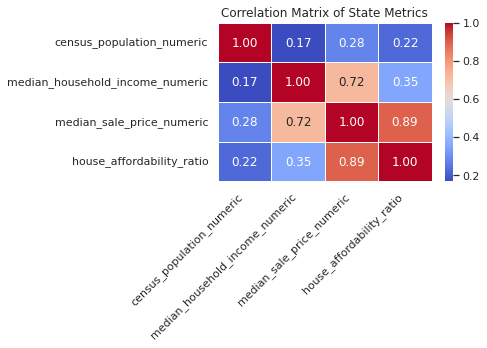

In [0]:
if not analysis_df.empty:
    print("\n--- Correlation Analysis ---")
    correlation_matrix = analysis_df[numeric_cols_for_corr].corr()
    print("Correlation Matrix:\n", correlation_matrix)

    plt.figure(figsize=(7, 5)) 
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of State Metrics')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(visualization_output_dir, 'state_metrics_correlation_heatmap.png'), bbox_inches='tight')
    plt.show()
else:
    print("Skipping Correlation Analysis: insufficient data.")


# Distribution Analysis


--- Distribution Analysis ---


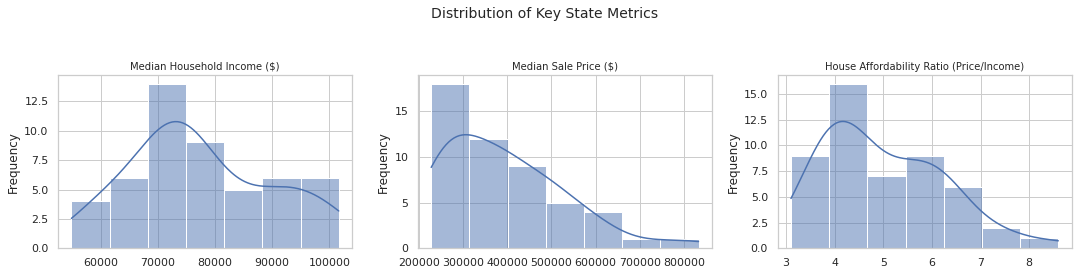

In [0]:
if not analysis_df.empty:
    print("\n--- Distribution Analysis ---")
    metrics_to_plot = {
        'median_household_income_numeric': 'Median Household Income ($)',
        'median_sale_price_numeric': 'Median Sale Price ($)',
        'house_affordability_ratio': 'House Affordability Ratio (Price/Income)'
    }

    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(15, 4)) 
    fig.suptitle('Distribution of Key State Metrics', fontsize=14)

    for i, (col, label) in enumerate(metrics_to_plot.items()):
        sns.histplot(analysis_df[col], kde=True, ax=axes[i])
        axes[i].set_title(label, fontsize=10) 
        axes[i].set_xlabel('') 
        axes[i].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) 
    plt.savefig(os.path.join(visualization_output_dir, 'state_metrics_distributions.png'), bbox_inches='tight')
    plt.show()
else:
    print("Skipping Distribution Analysis: insufficient data.")

# Affordability Analysis


--- Top/Bottom States by Affordability ---

Top 5 Most Affordable:
      key_row  house_affordability_ratio
14      iowa                        3.1
12  illinois                        3.5
21  michigan                        3.5
34      ohio                        3.5
13   indiana                        3.6

Bottom 5 Least Affordable:
        key_row  house_affordability_ratio
4   california                        8.6
10      hawaii                        7.5
25     montana                        7.5
31    new_york                        6.8
46  washington                        6.6


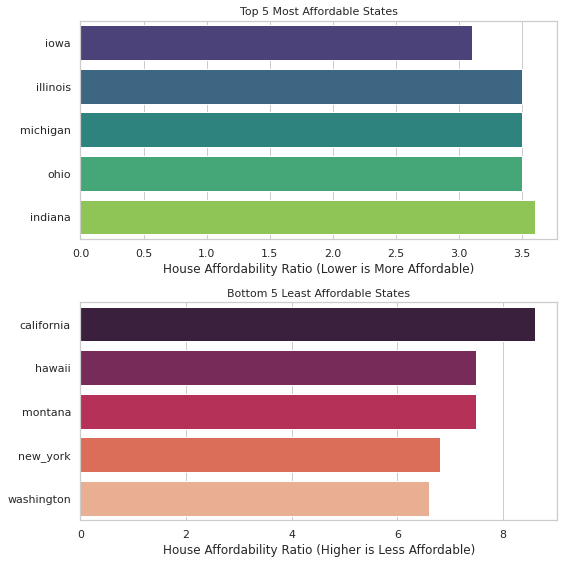

In [0]:
plot_df = final_df.dropna(subset=['house_affordability_ratio', 'key_row']).copy()

if not plot_df.empty:
    print("\n--- Top/Bottom States by Affordability ---")
    n_states = 5
    plot_df_sorted = plot_df.sort_values('house_affordability_ratio', ascending=True)
    top_n = plot_df_sorted.head(n_states)
    bottom_n = plot_df_sorted.tail(n_states).sort_values('house_affordability_ratio', ascending=False)

    print(f"\nTop {n_states} Most Affordable:\n", top_n[['key_row', 'house_affordability_ratio']])
    print(f"\nBottom {n_states} Least Affordable:\n", bottom_n[['key_row', 'house_affordability_ratio']])

    fig, axes = plt.subplots(2, 1, figsize=(8, 8)) 
    sns.barplot(data=top_n, x='house_affordability_ratio', y='key_row', ax=axes[0], palette='viridis')
    axes[0].set_title(f'Top {n_states} Most Affordable States', fontsize=11)
    axes[0].set_xlabel('House Affordability Ratio (Lower is More Affordable)')
    axes[0].set_ylabel('')

    sns.barplot(data=bottom_n, x='house_affordability_ratio', y='key_row', ax=axes[1], palette='rocket')
    axes[1].set_title(f'Bottom {n_states} Least Affordable States', fontsize=11)
    axes[1].set_xlabel('House Affordability Ratio (Higher is Less Affordable)')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.savefig(os.path.join(visualization_output_dir, 'state_affordability_rankings.png'), bbox_inches='tight')
    plt.show()
else:
    print("Skipping Top/Bottom Affordability analysis: insufficient data.")